In [1]:
import requests
import os
from pathlib import Path
import pickle
import logging
from time import sleep
from tqdm import tqdm
import sys

In [2]:
processed_ids_file='data/processed_ids.pickle'
papers_data_file='data/papers_data.pickle'
s2_map_file='data/s2_map.pickle'
paper_index = pickle.load(open(papers_data_file, "rb")) if os.path.exists(papers_data_file) else {}
processed = pickle.load(open(processed_ids_file, "rb")) if os.path.exists(processed_ids_file) else []
s2_map = pickle.load(open(s2_map_file, "rb")) if os.path.exists(s2_map_file) else {}

test graph

In [3]:
test_papers_records = {}
node_id = 0
data_dir='data/dataset_papers'
folder_names = [i.name for i in Path(data_dir).glob("*/")]
arxiv_to_id = {}

for folder_name in tqdm(folder_names):
    test_papers_records[node_id] = {'arxiv_id': folder_name}
    arxiv_to_id[folder_name] = node_id
    node_id += 1

100%|██████████| 6545/6545 [00:00<00:00, 18721.37it/s]


In [6]:
#iterate over test_papers_records and extract the paper data
edges = []
ref_node_not_found_count = 0
for i, (node_id, paper) in enumerate(test_papers_records.items()):
    # source_node_id = int(node_id)
    source_arxiv_id = paper['arxiv_id']
    paper_record = paper_index.get(source_arxiv_id)
    if paper_record is None:
        print(f"Paper {source_arxiv_id} not found in index.")
        raise ValueError(f"Paper {source_arxiv_id} not found in index.")
    
    #iterate over paper references
    references = paper_record.get('references')
    if references is None:
        # print(f"Paper {arxiv_id} has no references.")
        url = f"https://api.semanticscholar.org/graph/v1/paper/ARXIV:{source_arxiv_id.split('v')[0]}"
        params = {
            "fields": "paperId,corpusId,externalIds,url,title,abstract,venue,year,citationCount,influentialCitationCount,referenceCount,fieldsOfStudy,publicationTypes,authors.authorId,authors.name,authors.externalIds,authors.affiliations,authors.paperCount,authors.citationCount,authors.hIndex,authors.url,authors.homepage,references.paperId,references.title,references.abstract,references.venue,references.year,references.citationCount,references.referenceCount,references.fieldsOfStudy,references.influentialCitationCount,references.authors"
        }
        headers = {"User-Agent": "CitationBot/1.0"}

        response = requests.get(url, params=params, headers=headers)

        info_with_references = response.json()
        info_with_references['s2_paperId'] = info_with_references.pop('paperId', None)
        for key, value in info_with_references.items():
            paper_index[source_arxiv_id][key] = value
        print(f"Paper {source_arxiv_id} has no references. Fetched from S2 API.")
        # raise ValueError(f"Paper {arxiv_id} has no references.")
        if references is None:
            continue
    for ref in references:
        if ref['paperId'] in s2_map:
            target_arxiv_id = s2_map[ref['paperId']]
            # target_node_id = arxiv_to_id.get(target_arxiv_id)
            # edges.append((source_node_id, target_node_id))
            edges.append((source_arxiv_id, target_arxiv_id))
        else:
            ref_node_not_found_count += 1

# papers not found in S2 API, added by parsing bib and bbl files
missing_papers = {'2002.07217v3' : ['1506.02557v2', '1808.09034v3', '1805.11284v2', '1802.04942v5', '1802.04537v3'],
'2405.15306v3': ['2304.08485v2', '1609.04938v2'],
'2110.14859v1': ['2103.03868v1', '2103.03868v1', '1502.02643v1', '1709.01249v4', '1312.5179v1', '1803.03851v3'],
'2002.02405v2': ['1810.04045v3', '1812.03973v3']}

for k, v in missing_papers.items():
    source = k
    for i in v:
        dest = i
        edges.append((source, dest))
            


Paper 1108.6211v2 has no references. Fetched from S2 API.
Paper 1902.02671v2 has no references. Fetched from S2 API.
Paper 2002.07217v3 has no references. Fetched from S2 API.
Paper 2405.15306v3 has no references. Fetched from S2 API.
Paper 1806.02867v5 has no references. Fetched from S2 API.
Paper 2005.08543v3 has no references. Fetched from S2 API.
Paper 1905.09263v5 has no references. Fetched from S2 API.
Paper 2110.14859v1 has no references. Fetched from S2 API.
Paper 2002.02405v2 has no references. Fetched from S2 API.
Paper 1312.3393v2 has no references. Fetched from S2 API.
Paper 2406.14546v3 has no references. Fetched from S2 API.
Paper 1906.06321v2 has no references. Fetched from S2 API.


In [7]:
import networkx as nx
G = nx.DiGraph()

# add edges to the graph
G.add_edges_from(edges)

# add nodes to the graph
# iterate over folder names and read title and abstract from each folder
for folder_name in tqdm(folder_names):
    # create a new node for each folder
    node_id = arxiv_to_id[folder_name]
    G.add_node(folder_name)
    # iterate over the files in the folder
    title = open(Path(data_dir) / folder_name / "title.txt", "r").readlines()
    abstract = open(Path(data_dir) / folder_name / "abstract.txt", "r").readlines()
    G.nodes[folder_name]['title'] = title
    G.nodes[folder_name]['abstract'] = abstract



100%|██████████| 6545/6545 [17:19<00:00,  6.29it/s]


In [18]:
pickle.dump(G, open('data/graph/student_graph.pickle', "wb"))

In [10]:
# The number of edges in the graph.
# Number of isolated nodes in the graph.
# The average degree (in-degree, out-degree). Plot a histogram of the degrees of nodes.
# Diameter of the graph.

print(f"Number of edges in the graph: {G.number_of_edges()}")
print(f"Number of isolated nodes in the graph: {len(list(nx.isolates(G)))}")
print(f"Average in-degree: {sum(dict(G.in_degree()).values())/G.number_of_nodes()}")
print(f"Average out-degree: {sum(dict(G.out_degree()).values())/G.number_of_nodes()}")

# Get the undirected version of the graph for connected components analysis
G_undirected = G.to_undirected()

# Find all connected components
connected_components = list(nx.connected_components(G_undirected))
print(f"Number of connected components: {len(connected_components)}")


# Get the largest connected component
largest_cc = max(nx.connected_components(G.to_undirected()), key=len)
largest_cc_subgraph = G.to_undirected().subgraph(largest_cc)

# Calculate diameter on the largest component only
print(f"Diameter of the largest connected component: {nx.diameter(largest_cc_subgraph)}")

# find diameter of largetst strongly connected component
strongly_connected_components = list(nx.strongly_connected_components(G))
largest_scc = max(strongly_connected_components, key=len)
largest_scc_subgraph = G.subgraph(largest_scc)
# Calculate diameter on the largest strongly connected component only
print(f"Diameter of the largest strongly connected component: {nx.diameter(largest_scc_subgraph)}")

Number of edges in the graph: 17772
Number of isolated nodes in the graph: 720
Average in-degree: 2.715355233002292
Average out-degree: 2.715355233002292
Number of connected components: 759
Diameter of the largest connected component: 16
Diameter of the largest strongly connected component: 5


Diameter of the largest strongly connected component: 5


Answers to part 1:
- Number of edges in the graph: 17772
- Number of isolated nodes in the graph: 720
- Average in-degree: 2.715355233002292
- Average out-degree: 2.715355233002292
- Number of connected components: 759
- Diameter of the largest connected component: 16

In [13]:
# save graph to file
output_dir = 'data/graph'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
pickle.dump(G, open(os.path.join(output_dir, "student_graph.pickle"), "wb"))

In [8]:
import pickle
import networkx as nx
G = pickle.load(open('data/graph/student_graph.pickle', "rb"))

In [3]:
# isolated nodes
isolated_nodes = list(nx.isolates(G))
sorted(isolated_nodes)

['0709.0928v1',
 '0808.3129v2',
 '0909.1884v2',
 '0910.2279v1',
 '1003.0024v1',
 '1005.0027v2',
 '1005.1860v2',
 '1005.5581v2',
 '1008.5325v4',
 '1010.3812v2',
 '1011.0415v1',
 '1102.0836v2',
 '1103.0790v1',
 '1103.2816v2',
 '1108.4217v1',
 '1108.6211v2',
 '1204.5243v2',
 '1205.4213v2',
 '1206.1800v1',
 '1206.1898v2',
 '1207.2491v1',
 '1209.1145v1',
 '1209.2784v1',
 '1209.3230v1',
 '1210.1121v1',
 '1211.0439v1',
 '1211.4321v1',
 '1301.4171v1',
 '1302.3639v5',
 '1302.3979v1',
 '1303.0551v2',
 '1303.4664v1',
 '1303.6977v4',
 '1304.3285v4',
 '1304.4610v2',
 '1304.5575v2',
 '1304.7717v2',
 '1305.2532v1',
 '1306.3285v1',
 '1306.4355v1',
 '1307.8187v2',
 '1308.6342v4',
 '1310.0432v1',
 '1310.8613v2',
 '1311.0072v1',
 '1311.1903v1',
 '1311.2241v1',
 '1311.4527v1',
 '1312.1099v1',
 '1312.3393v2',
 '1401.1974v4',
 '1402.3085v1',
 '1402.3902v4',
 '1403.0504v2',
 '1405.4273v1',
 '1405.5156v1',
 '1406.0189v1',
 '1407.4508v2',
 '1409.0289v2',
 '1409.3215v3',
 '1410.4210v1',
 '1410.6834v2',
 '1411.1

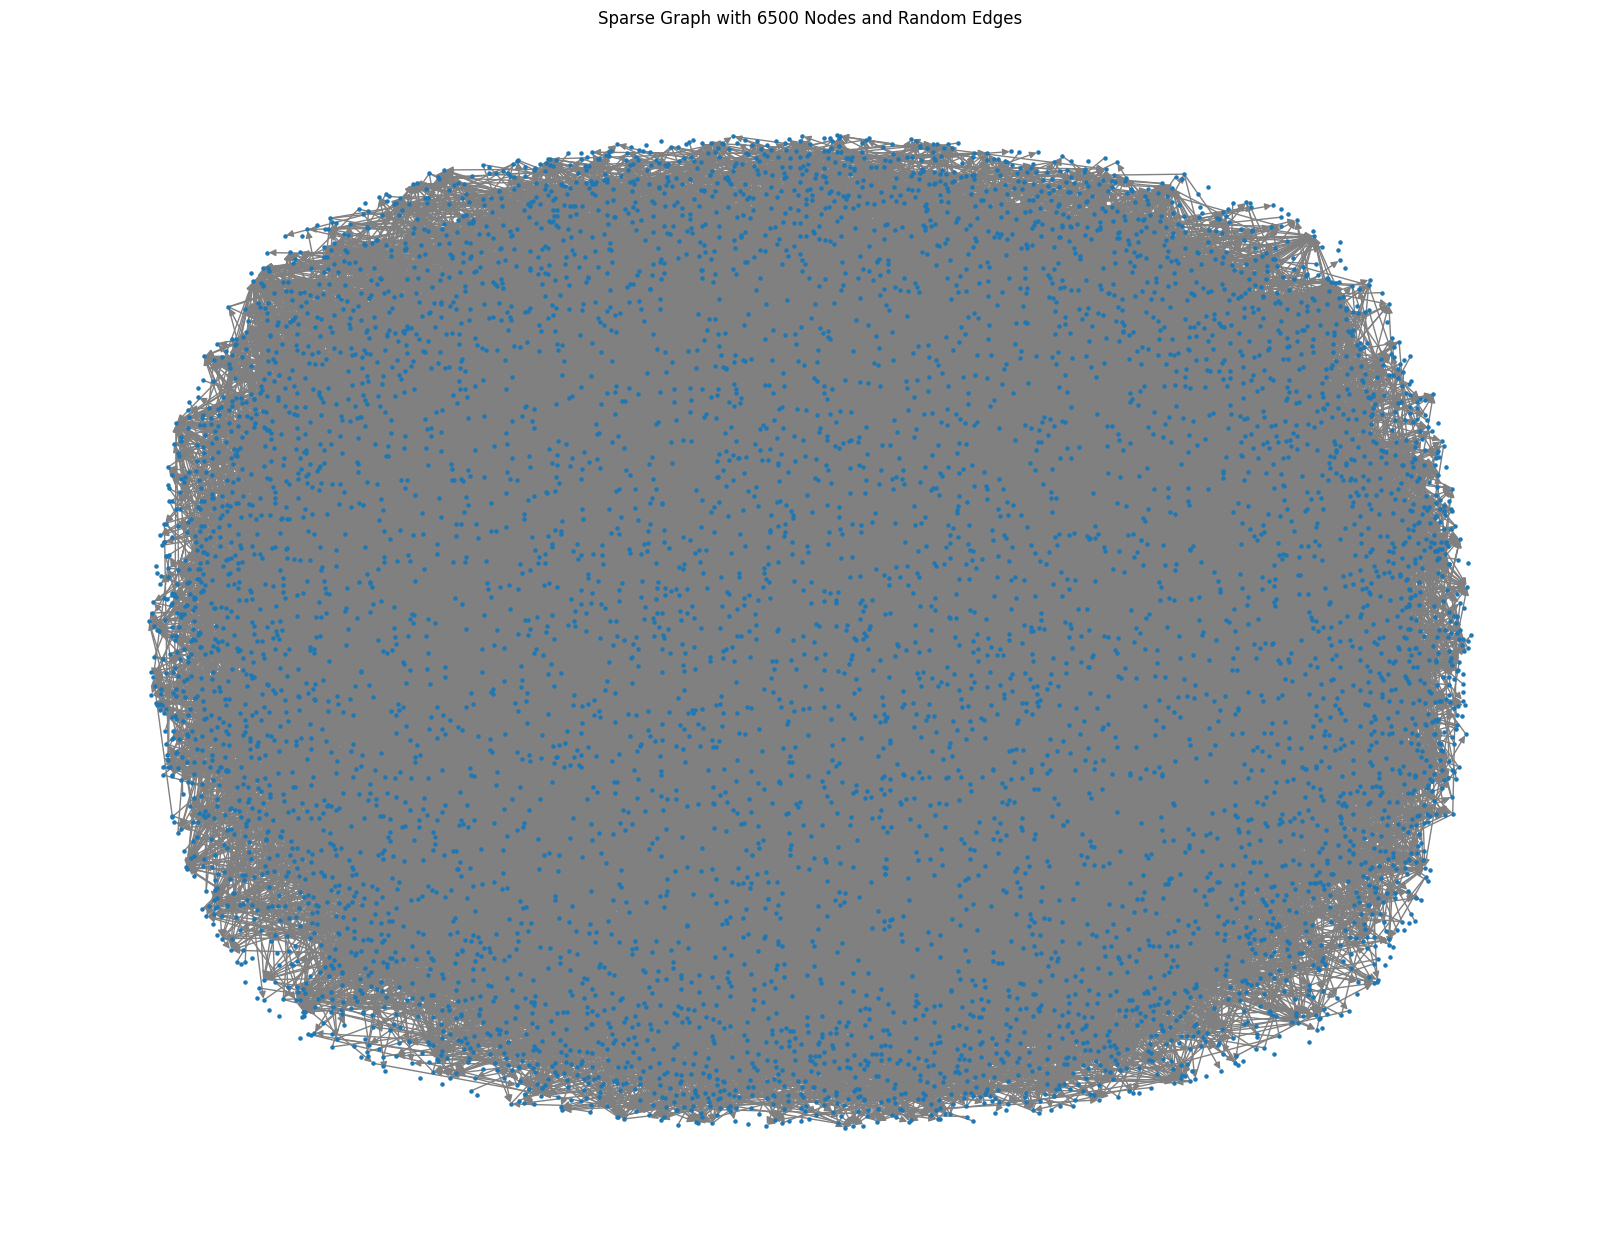

In [7]:
# draw the graph
import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns
# import matplotlib.cm as cm
# import matplotlib.colors as mcolors
# import matplotlib.patches as mpatches

# Optional: use a layout optimized for large graphs
pos = nx.spring_layout(G, seed=42, k=0.15, iterations=20)  # can be slow for 6500 nodes

# Draw (you can skip node labels for performance)
plt.figure(figsize=(16, 12))
nx.draw(G, pos, node_size=5, edge_color='gray', with_labels=False)
plt.title("Sparse Graph with 6500 Nodes and Random Edges")
plt.axis('off')
plt.show()

non sense

In [30]:
# each paper_index entry is a dictionary 
# find keywise number of papers with None in that key across all papers
def count_none_values(paper_index):
    none_counts = {}
    for paper_id, paper_data in paper_index.items():
        for key, value in paper_data.items():
            if value is None:
                if key not in none_counts:
                    none_counts[key] = 0
                none_counts[key] += 1
    return none_counts
none_counts = count_none_values(paper_index)
print("Number of papers with None in each key:")
for key, count in none_counts.items():
    print(f"{key}: {count}")

# find paper with abstract None
def find_paper_with_none_abstract(paper_index):
    for paper_id, paper_data in paper_index.items():
        if paper_data.get('abstract') is None:
            return paper_id, paper_data
    return None, None
paper_id, paper_data = find_paper_with_none_abstract(paper_index)
print(f"Paper ID with None abstract: {paper_id}")
print(f"Paper data: {paper_data}")

Number of papers with None in each key:
publicationTypes: 33
Paper ID with None abstract: None
Paper data: None


In [ ]:
# iterate over all the papers and extract paper data 
for i, (paper_id, paper) in enumerate(paper_index.items()):
    paper_record = test_papers_records
    test_papers_records[node_id] = {'arxiv_id': paper['arxiv_id'], 'title': paper['title'], 'abstract': paper['abstract']}
    for reference in paper['references']:
        if reference['papedId'] in s2_map:
            record[reference] = {'title': s2_map[reference]['title'], 'abstract': s2_map[reference]['abstract']}

TypeError: unhashable type: 'dict'

In [ ]:
# Paper 1108.6211v2 has no references. Fetched from S2 API.
# Paper 1902.02671v2 has no references. Fetched from S2 API.
# Paper 2002.07217v3 has no references. Fetched from S2 API.
# Paper 2405.15306v3 has no references. Fetched from S2 API.
# Paper 1305.3120v1 has no references. Fetched from S2 API.
# Paper 1806.02867v5 has no references. Fetched from S2 API.
# Paper 2005.08543v3 has no references. Fetched from S2 API.
# Paper 1905.09263v5 has no references. Fetched from S2 API.
# Paper 2110.14859v1 has no references. Fetched from S2 API.
# Paper 2002.02405v2 has no references. Fetched from S2 API.
# Paper 1312.3393v2 has no references. Fetched from S2 API.
# Paper 2406.14546v3 has no references. Fetched from S2 API.
# Paper 1906.06321v2 has no references. Fetched from S2 API.
# 
foo = ["1305.3120v1"]

for i in foo:
    bar = i.split('v')[0]
    url = f"https://api.semanticscholar.org/graph/v1/paper/ARXIV:{bar}"
    params = {
        "fields": "paperId,corpusId,externalIds,url,title,abstract,venue,year,citationCount,influentialCitationCount,referenceCount,fieldsOfStudy,publicationTypes,authors.authorId,authors.name,authors.externalIds,authors.affiliations,authors.paperCount,authors.citationCount,authors.hIndex,authors.url,authors.homepage,references.paperId,references.title,references.abstract,references.venue,references.year,references.citationCount,references.referenceCount,references.fieldsOfStudy,references.influentialCitationCount,references.authors"
    }
    headers = {"User-Agent": "CitationBot/1.0"}

    response = requests.get(url, params=params, headers=headers)

    print(response.json())

{'paperId': '4cc7507032779128bfc1b648a7892214c4eb6c43', 'externalIds': {'MAG': '2106833843', 'ArXiv': '1305.3120', 'DBLP': 'conf/icml/Mairal13', 'CorpusId': 6038174}, 'corpusId': 6038174, 'url': 'https://www.semanticscholar.org/paper/4cc7507032779128bfc1b648a7892214c4eb6c43', 'title': 'Optimization with First-Order Surrogate Functions', 'abstract': 'In this paper, we study optimization methods consisting of iteratively minimizing surrogates of an objective function. By proposing several algorithmic variants and simple convergence analyses, we make two main contributions. First, we provide a unified viewpoint for several first-order optimization techniques such as accelerated proximal gradient, block coordinate descent, or Frank-Wolfe algorithms. Second, we introduce a new incremental scheme that experimentally matches or outperforms state-of-the-art solvers for large-scale optimization problems typically arising in machine learning.', 'venue': 'International Conference on Machine Learn

In [57]:
response.json()

{'error': 'Paper with id ARXIV:1108.6211 not found'}

In [50]:
info_with_references = response.json()
info_with_references['s2_paperId'] = info_with_references.pop('paperId', None)

In [52]:
for key, value in info_with_references.items():
    paper_index['1502.03167v3'][key] = value

In [61]:
pickle.dump(paper_index, open('data/papers_data.pickle', "wb"))

In [49]:
len(folder_names)

6545

In [76]:
# 1108.6211v2
# 1902.02671v2
# 2002.07217v3
# 2405.15306v3
# 1305.3120v1
# 1806.02867v5
# 2005.08543v3
# 1905.09263v5
# 2110.14859v1
# 2002.02405v2
# 1312.3393v2
# 2406.14546v3
# 1906.06321v2
special_papers = ["1108.6211v2", "1902.02671v2", "2002.07217v3", "2405.15306v3", "1305.3120v1", "1806.02867v5", "2005.08543v3", "1905.09263v5", "2110.14859v1", "2002.02405v2", "1312.3393v2", "2406.14546v3", "1906.06321v2"]
bbl_files = []
bib_files = []
for i in special_papers:
    # list all files in the directory
    directory = f"data/dataset_papers/{i}"
    files = os.listdir(directory)
    for f in files:
        if ".bbl" in f:
            # add complete path to the file
            f = os.path.join(directory, f)
            bbl_files.append(f)
        if ".bib" in f:
            # add complete path to the file
            f = os.path.join(directory, f)
            bib_files.append(f)
    # iterate over all the files in the directory
print(bbl_files)
print(bib_files)

['data/dataset_papers/1108.6211v2/sourcetransfer-tech.bbl', 'data/dataset_papers/1902.02671v2/d.bbl', 'data/dataset_papers/2002.07217v3/neurips_2020.bbl', 'data/dataset_papers/2405.15306v3/detikzify.bbl', 'data/dataset_papers/1305.3120v1/sup.bbl', 'data/dataset_papers/1305.3120v1/main.bbl', 'data/dataset_papers/1806.02867v5/neurips_2019.bbl', 'data/dataset_papers/2005.08543v3/SyPI_Mastakouri.bbl', 'data/dataset_papers/1905.09263v5/neurips2019.bbl', 'data/dataset_papers/2110.14859v1/main-arXiv.bbl', 'data/dataset_papers/2002.02405v2/arxiv.bbl', 'data/dataset_papers/1312.3393v2/icml2014-rucb.bbl', 'data/dataset_papers/2406.14546v3/main.bbl', 'data/dataset_papers/1906.06321v2/linear_q.bbl']
['data/dataset_papers/2002.07217v3/biblio.bib', 'data/dataset_papers/2405.15306v3/detikzify.bib', 'data/dataset_papers/1806.02867v5/neurips_2019.bib', 'data/dataset_papers/1905.09263v5/neurips2019.bib', 'data/dataset_papers/2110.14859v1/main-arXiv.bib', 'data/dataset_papers/2002.02405v2/arxiv.bib']


In [75]:
title_to_id = {}
for i in tqdm(folder_names):
    path = f"data/dataset_papers/{i}"
    title_path = os.path.join(path, "title.txt")
    title_text = open(title_path, "r").read()
    title_to_id[title_text] = i

100%|██████████| 6545/6545 [00:22<00:00, 287.61it/s]


In [78]:
title_to_id
# save to pickle
pickle.dump(title_to_id, open('data/title_to_arxiv_id.pickle', "wb"))

In [ ]:
missing_papers = {'2002.07217v3' : ['1506.02557v2', '1808.09034v3', '1805.11284v2', '1802.04942v5', '1802.04537v3'],
'2405.15306v3': ['2304.08485v2', '1609.04938v2'],
'2110.14859v1': ['2103.03868v1', '2103.03868v1', '1502.02643v1', '1709.01249v4', '1312.5179v1', '1803.03851v3'],
'2002.02405v2': ['1810.04045v3', '1812.03973v3']}

for k, v in missing_papers.items():
    source = arxiv_to_id[k]
    for i in v:
        dest = arxiv_to_id[i]
        edges.append((source, dest))

In [ ]:
edges = []
f


In [82]:
edges

[(1047, 564),
 (1047, 1272),
 (1047, 3919),
 (1047, 6324),
 (1047, 2373),
 (1503, 47),
 (1503, 2331),
 (4864, 5337),
 (4864, 5337),
 (4864, 2191),
 (4864, 2898),
 (4864, 1818),
 (4864, 4316),
 (5470, 2129),
 (5470, 3369)]